In [1]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as tv
import torch.optim as optim
from PIL import Image
import logging
import matplotlib.pyplot as plt
import copy
import pandas as pd
from statistics import mean
%matplotlib inline

In [2]:
mylogs = logging.getLogger()
mylogs.setLevel(logging.INFO)
# Logging to file
file = logging.FileHandler("training.log", mode='w')
file.setLevel(logging.INFO)
fileformat = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s",datefmt="%H:%M:%S")
file.setFormatter(fileformat)
mylogs.addHandler(file)
# Logging to console
stream = logging.StreamHandler()
stream.setLevel(logging.INFO)
mylogs.addHandler(stream)

# Paths and parameters

In [3]:
# Input for data set woith labels in folder names
train_dir = r"E:/colon_dataset/mucosa/"
#train_dir = r"E:/datasets/faces/"
model_name = 'DCGAN'
project_name = "Pathology images generation"

In [4]:
mylogs.info("generative adversarial network")
mylogs.info(f"Project : {project_name}")

generative adversarial network
Project : Pathology images generation


In [5]:
def create_img_list(folder):
    img_list = []
    img_list = list()
    for (dirpath, dirnames, filenames) in os.walk(folder):
            img_list += [os.path.join(dirpath, file) for file in filenames]
    return img_list

In [6]:
train_img_list = create_img_list(train_dir)

In [7]:
# Set random seed for reproducibility
manualSeed = 888
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  888


In [8]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 32


# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5


# Image Loading functions

In [9]:
def get_train_transform():
    return tv.Compose([
        tv.CenterCrop(image_size),
        tv.ToTensor(),
#        tv.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])



In [10]:
class loadDataset(Dataset):
    def __init__(self, image_size, img_list, transforms,):
        super().__init__()
        self.imgs = img_list
        self.transforms = transforms
        self.image_size = image_size
        
    def __getitem__(self, idx):
        image_path = self.imgs[idx]
      ### Reading, converting and normalizing image
            ### Reading, converting and normalizing image
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = self.transforms(img)
        return img
        
    def __len__(self):
        return len(self.imgs)

In [11]:
train_dataset = loadDataset(image_size, train_img_list,
                            transforms = get_train_transform())

In [12]:
train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 0,
    batch_size = 64,
    pin_memory = True,
    shuffle = True
)


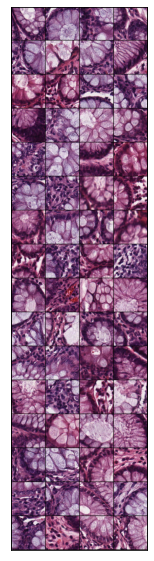

In [13]:
def dataset_preview(train_data_loader):
    for images in train_data_loader:
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 4).permute(1,2,0))
        break
        
dataset_preview(train_data_loader)

# Functions for training

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mylogs.info(f"Device is: {str(device)}")

Device is: cuda


In [15]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
import GAN
# Create the generator
netG = GAN.Generator(nz,ngf,nc)
netG = netG.to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

In [17]:
# Create the Discriminator
netD = GAN.Discriminator(nc, ndf)
netD = netD.to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, mom

In [18]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
mylogs.info("Model: " + model_name )

Model: DCGAN


In [20]:
def train_one_epoch(data_loader,model_G, model_D, optimizer_G, optimizer_D):
    # soft label
    real_label = random.uniform(0.7,0.99 )
    fake_label = random.uniform(0.01,0.3 )
    
    ### Local Parameters
    epoch_G_loss = []
    epoch_D_loss = []
    
    start_time = time.time()
    def adding_white_noise(image, epoch):
        #addswhite noise to input 
        mean = 0.5
        std = 0.1/(epoch+1)
        noise = (torch.randn(image.shape[0], 3, image.shape[2], image.shape[3]) + mean) * std
        image = image + noise
        return image

    
    ###Iterating over data loader
    for epoch, image in enumerate(data_loader, 0):
        image = adding_white_noise(image, epoch)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        #real_cpu = image[0].to(device)
        real_cpu = image.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        end_time = time.time()
        total_time = int(end_time - start_time)/60
        # Save Losses for plotting later
        epoch_G_loss.append(errG.item())
        epoch_D_loss.append(errD.item())

    return mean(epoch_G_loss), mean(epoch_D_loss), total_time

In [21]:
def report_in_progress(epoch, G_loss, D_loss, _time):
       #Print epoch details
        mylogs.info(f'Training: Epoch {epoch}: | G_Loss: {G_loss:.5f} | D_loss: {D_loss:.3f} | Time: {(round(_time, 4))}')

In [22]:
def train_model(data_loader, model_G, model_D, optimizer_G, optimizer_D, max_n_epochs):
    fixed_noise = torch.randn(128, nz, 1, 1, device=device)
    
    start_time = time.time()
    # initializing  training stats
    train_logs =  {"G_loss" : [], "D_loss" : [], "time" : []}
    mylogs.info("Training started")
    current_epoch = 0
    img_list = []
    for epoch in range(1, max_n_epochs + 1):
        G_loss, D_loss, train_time = train_one_epoch(data_loader, model_G, model_D,
                                                 optimizer_G, optimizer_D)
        #Print train Epoch Details      
        report_in_progress( epoch, G_loss, D_loss, train_time)
            #Adding stats for the epoch
        train_logs["G_loss"].append(G_loss)
        train_logs["D_loss"].append(D_loss)
        train_logs["time"].append(train_time)
          # saving progress images
        if epoch in range(1, max_n_epochs + 1, 5):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))
       
    end_time = time.time()
    total_time = end_time - start_time
    mylogs.info(f"Total time : {int(total_time/60)}")
    # packing training data into a dictionary
    training_stats = {}
    training_stats['train logs'] = train_logs
    
    # Check how the generator is doing by saving G's output on fixed_noise
    generator_state_dict = model_G.state_dict()
    return (model_G, model_D),generator_state_dict, training_stats, img_list

In [23]:
# Training de novo
n_of_epochs = 500
model, generator_state_dict, training_stats, img_list = train_model(train_data_loader, netG, netD, optimizerG, optimizerD, n_of_epochs)

Training started
Training: Epoch 1: | G_Loss: 1.34278 | D_loss: 4.077 | Time: 0.1333
Training: Epoch 2: | G_Loss: 2.64427 | D_loss: 6.031 | Time: 0.1
Training: Epoch 3: | G_Loss: 5.55311 | D_loss: 3.554 | Time: 0.1
Training: Epoch 4: | G_Loss: 5.95160 | D_loss: 3.370 | Time: 0.1
Training: Epoch 5: | G_Loss: 6.47572 | D_loss: 2.660 | Time: 0.1
Training: Epoch 6: | G_Loss: 6.08575 | D_loss: 3.160 | Time: 0.1
Training: Epoch 7: | G_Loss: 5.30281 | D_loss: 2.189 | Time: 0.1
Training: Epoch 8: | G_Loss: 3.62849 | D_loss: 2.053 | Time: 0.1
Training: Epoch 9: | G_Loss: 3.58820 | D_loss: 1.553 | Time: 0.1
Training: Epoch 10: | G_Loss: 4.41671 | D_loss: 1.620 | Time: 0.1167
Training: Epoch 11: | G_Loss: 3.70273 | D_loss: 2.038 | Time: 0.1
Training: Epoch 12: | G_Loss: 4.83259 | D_loss: 1.349 | Time: 0.1
Training: Epoch 13: | G_Loss: 3.49458 | D_loss: 1.607 | Time: 0.1
Training: Epoch 14: | G_Loss: 4.04846 | D_loss: 1.399 | Time: 0.1
Training: Epoch 15: | G_Loss: 2.26666 | D_loss: 1.612 | Time: 

Training: Epoch 123: | G_Loss: 0.78997 | D_loss: 1.288 | Time: 0.1
Training: Epoch 124: | G_Loss: 0.90446 | D_loss: 1.331 | Time: 0.1
Training: Epoch 125: | G_Loss: 1.08047 | D_loss: 1.237 | Time: 0.1
Training: Epoch 126: | G_Loss: 1.23441 | D_loss: 1.167 | Time: 0.1
Training: Epoch 127: | G_Loss: 1.20385 | D_loss: 1.117 | Time: 0.1
Training: Epoch 128: | G_Loss: 1.05430 | D_loss: 1.234 | Time: 0.1
Training: Epoch 129: | G_Loss: 1.19824 | D_loss: 1.233 | Time: 0.1
Training: Epoch 130: | G_Loss: 0.98674 | D_loss: 1.331 | Time: 0.1
Training: Epoch 131: | G_Loss: 1.31966 | D_loss: 1.136 | Time: 0.1
Training: Epoch 132: | G_Loss: 1.01466 | D_loss: 1.293 | Time: 0.1
Training: Epoch 133: | G_Loss: 0.98830 | D_loss: 1.270 | Time: 0.1
Training: Epoch 134: | G_Loss: 1.09956 | D_loss: 1.238 | Time: 0.1
Training: Epoch 135: | G_Loss: 1.28577 | D_loss: 1.175 | Time: 0.1
Training: Epoch 136: | G_Loss: 1.21274 | D_loss: 1.202 | Time: 0.1
Training: Epoch 137: | G_Loss: 1.30656 | D_loss: 1.242 | Time:

Training: Epoch 245: | G_Loss: 1.20569 | D_loss: 0.976 | Time: 0.1
Training: Epoch 246: | G_Loss: 1.38630 | D_loss: 1.019 | Time: 0.1
Training: Epoch 247: | G_Loss: 1.36548 | D_loss: 1.030 | Time: 0.1
Training: Epoch 248: | G_Loss: 1.13588 | D_loss: 1.108 | Time: 0.1167
Training: Epoch 249: | G_Loss: 1.41929 | D_loss: 0.859 | Time: 0.1167
Training: Epoch 250: | G_Loss: 1.47620 | D_loss: 0.960 | Time: 0.1
Training: Epoch 251: | G_Loss: 1.30618 | D_loss: 1.107 | Time: 0.1
Training: Epoch 252: | G_Loss: 1.40056 | D_loss: 0.993 | Time: 0.1
Training: Epoch 253: | G_Loss: 1.22914 | D_loss: 1.010 | Time: 0.1
Training: Epoch 254: | G_Loss: 1.68303 | D_loss: 1.190 | Time: 0.1
Training: Epoch 255: | G_Loss: 1.25191 | D_loss: 1.057 | Time: 0.1
Training: Epoch 256: | G_Loss: 1.86189 | D_loss: 0.929 | Time: 0.1
Training: Epoch 257: | G_Loss: 1.64751 | D_loss: 0.941 | Time: 0.1
Training: Epoch 258: | G_Loss: 1.73403 | D_loss: 0.819 | Time: 0.1
Training: Epoch 259: | G_Loss: 1.10911 | D_loss: 1.195 |

Training: Epoch 368: | G_Loss: 1.57086 | D_loss: 1.003 | Time: 0.1
Training: Epoch 369: | G_Loss: 1.29216 | D_loss: 1.130 | Time: 0.1
Training: Epoch 370: | G_Loss: 1.39839 | D_loss: 1.042 | Time: 0.1
Training: Epoch 371: | G_Loss: 1.30737 | D_loss: 1.094 | Time: 0.1
Training: Epoch 372: | G_Loss: 1.85306 | D_loss: 0.600 | Time: 0.1
Training: Epoch 373: | G_Loss: 1.72844 | D_loss: 0.788 | Time: 0.1
Training: Epoch 374: | G_Loss: 1.75733 | D_loss: 0.946 | Time: 0.1
Training: Epoch 375: | G_Loss: 1.88974 | D_loss: 0.734 | Time: 0.1
Training: Epoch 376: | G_Loss: 1.35734 | D_loss: 0.856 | Time: 0.1
Training: Epoch 377: | G_Loss: 2.17239 | D_loss: 0.867 | Time: 0.1
Training: Epoch 378: | G_Loss: 2.02262 | D_loss: 0.742 | Time: 0.1
Training: Epoch 379: | G_Loss: 1.30576 | D_loss: 1.169 | Time: 0.1
Training: Epoch 380: | G_Loss: 2.11708 | D_loss: 0.628 | Time: 0.1
Training: Epoch 381: | G_Loss: 2.09844 | D_loss: 0.688 | Time: 0.1
Training: Epoch 382: | G_Loss: 1.42992 | D_loss: 1.029 | Time:

Training: Epoch 489: | G_Loss: 1.35303 | D_loss: 1.075 | Time: 0.1
Training: Epoch 490: | G_Loss: 1.23432 | D_loss: 1.199 | Time: 0.1
Training: Epoch 491: | G_Loss: 1.22514 | D_loss: 1.057 | Time: 0.1
Training: Epoch 492: | G_Loss: 1.87213 | D_loss: 0.598 | Time: 0.1
Training: Epoch 493: | G_Loss: 1.32817 | D_loss: 1.233 | Time: 0.1
Training: Epoch 494: | G_Loss: 2.10697 | D_loss: 0.596 | Time: 0.1
Training: Epoch 495: | G_Loss: 1.90098 | D_loss: 0.994 | Time: 0.1
Training: Epoch 496: | G_Loss: 1.48107 | D_loss: 1.085 | Time: 0.1
Training: Epoch 497: | G_Loss: 1.49581 | D_loss: 1.058 | Time: 0.1
Training: Epoch 498: | G_Loss: 1.89474 | D_loss: 0.667 | Time: 0.1
Training: Epoch 499: | G_Loss: 1.21019 | D_loss: 1.047 | Time: 0.1
Training: Epoch 500: | G_Loss: 1.60413 | D_loss: 1.113 | Time: 0.1
Total time : 59


# Saving and evaluating resulting model

In [24]:
def train_vis(training_stats,epochs):
    epochs = epochs + 1
    ### Plotting Results
    train_logs = training_stats['train logs']

#Loss
    plt.title("Loss",color='black')
    plt.plot(np.arange(1, epochs), train_logs['G_loss'], color = 'blue', label='Generator loss')
    plt.plot(np.arange(1, epochs), train_logs['D_loss'], color = 'orange', label='Discriminator loss')
    plt.xticks(ticks=range(1, epochs, 50), color='black')
    plt.yticks(color='black')
    plt.xlabel("Epochs", color = 'black')
    plt.ylabel("Loss", color = 'black')
    plt.show()


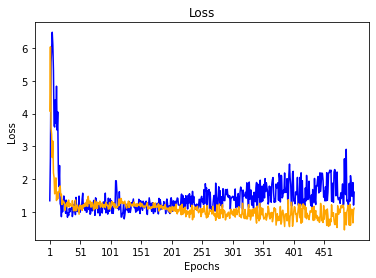

In [25]:
train_vis(training_stats,n_of_epochs)

In [26]:
from torchvision.utils import save_image

In [27]:
def training_save(img_list, path):
    n = 0
    for image in img_list:
        save_image(image, path + str(n)  + '.tif')
        n+=1
path = r'E:/colon_dataset/training/'        
training_save(img_list, path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


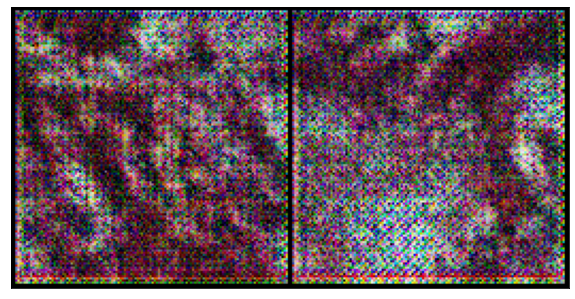

In [28]:
def generate_fake_images(generator,fixed_noise):
    fig, ax = plt.subplots(figsize = (10, 10))
    generator.to('cpu')
    fake = generator(fixed_noise)
    fake = fake.cpu() 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(fake, 4).permute(1,2,0))

fixed_noise = torch.randn(2, nz, 1, 1, device='cpu')
generate_fake_images(model[0], fixed_noise)

In [29]:
hyperparameters = {'image_size':image_size, 'nc': nc, 'nz': nz, 'ngf': ngf, 'ndf': ndf}

In [30]:
# Saving the best model
def save_model(model,generator_state_dict ,hyperparameters, training_stats, model_name):
    ''' Save model either for inference or for continuing training '''
    torch.save({'model_name': model_name,
                'model_state_dict': model[0].state_dict(),
                'hyperparameters': hyperparameters
                }, f'{project_name}_{model_name}_generator.pt')
    mylogs.info("Model saved")

In [31]:
save_model(model,generator_state_dict ,hyperparameters, training_stats, model_name)

Model saved
